This notebooks purpose is to get familiar with the utility function.

The first hing we have to understand is the utility function
$$U=S_{pat}-S_{rep}$$
which is the difference between the (normalised to the number of cells) Shannon entropy of the pattern distribution.

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# JAX imports
import jax
import jax.numpy as jnp
from jax import random

# Add src to path
sys.path.insert(0, '../src')

# Import our modules
from utility_function import (
    compute_entropy, compute_pattern_entropy, patterns_to_integers,
    compute_pattern_prob_distribution, compute_hard_reproducibility_entropy,
    compute_hard_utility, compute_hard_loss
)

# Setup plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

# Create figures directory if it doesn't exist
Path('../figures').mkdir(exist_ok=True)

print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print("✓ All imports successful")

JAX version: 0.4.35
JAX backend: cpu
✓ All imports successful


In [2]:
low_ent_probs = jnp.array([1.0, 0, 0, 0, 0])
high_ent_probs = jnp.array([0.2, 0.2, 0.2, 0.2, 0.2])

print("Computing entropies:")
print(f"Low entropy distribution: {low_ent_probs}, Entropy: {compute_entropy(low_ent_probs)}")
print(f"High entropy distribution: {high_ent_probs}, Entropy: {compute_entropy(high_ent_probs)}")

Computing entropies:
Low entropy distribution: [1. 0. 0. 0. 0.], Entropy: -0.0
High entropy distribution: [0.2 0.2 0.2 0.2 0.2], Entropy: 2.321928024291992


The Pattern Entropy is computed from the pooled distribution of cell fates. It simply asks what the distributions of different cell fates is:

In [3]:
low_ent_pattern1 = jnp.array([1, 1, 1, 1, 1])
low_ent_pattern2 = jnp.array([0, 0, 0, 0, 0])
high_ent_pattern1 = jnp.array([0, 1, 0, 1, 0])
high_ent_pattern2 = jnp.array([1, 0, 1, 0, 1])

print("Computing pattern entropies:")
print(f"First low entropy pattern: {low_ent_pattern1}, Entropy: {compute_pattern_entropy(low_ent_pattern1)}")
print(f"Second low entropy pattern: {low_ent_pattern2}, Entropy: {compute_pattern_entropy(low_ent_pattern2)}")
print(f"First high entropy pattern: {high_ent_pattern1}, Entropy: {compute_pattern_entropy(high_ent_pattern1)}")
print(f"Second high entropy pattern: {high_ent_pattern2}, Entropy: {compute_pattern_entropy(high_ent_pattern2)}")

Computing pattern entropies:
First low entropy pattern: [1 1 1 1 1], Entropy: -0.0
Second low entropy pattern: [0 0 0 0 0], Entropy: -0.0
First high entropy pattern: [0 1 0 1 0], Entropy: 0.9709505438804626
Second high entropy pattern: [1 0 1 0 1], Entropy: 0.9709505438804626


Testing pattern entropy (H_pattern):

1. All zeros: H_pattern = -0.0000 (expected: 0.0000)
   Interpretation: No diversity - all cells same fate

2. All ones: H_pattern = -0.0000 (expected: 0.0000)
   Interpretation: No diversity - all cells same fate

3. Perfect 50/50 split: H_pattern = 1.0000 (expected: 1.0000)
   Interpretation: Maximum diversity for binary fates


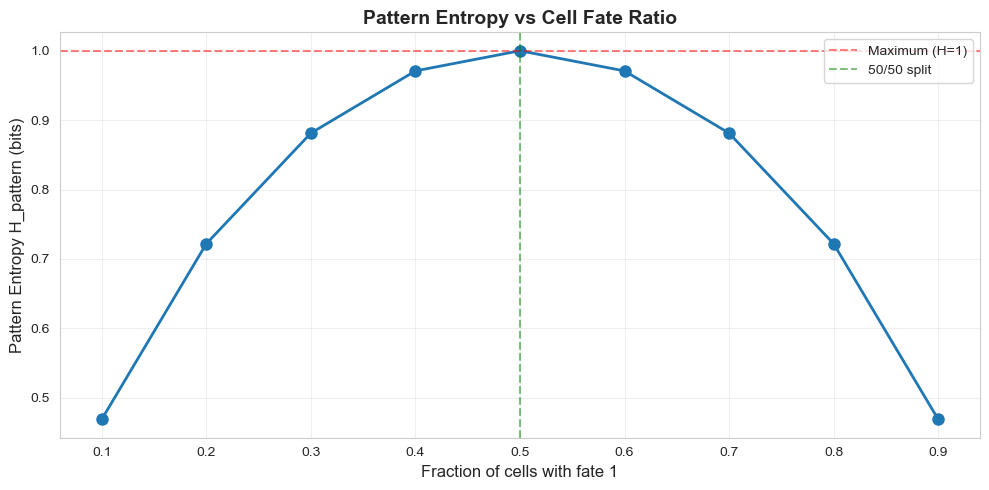


✓ Pattern entropy calculations correct!


In [4]:
print("Testing pattern entropy (H_pattern):")
print("=" * 50)

# Test 1: All cells fate 0
patterns = jnp.array([[0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0]])
h_p = compute_pattern_entropy(patterns)
print(f"\n1. All zeros: H_pattern = {h_p:.4f} (expected: 0.0000)")
print(f"   Interpretation: No diversity - all cells same fate")
assert abs(h_p) < 1e-4, "All zeros should give H_pattern = 0"

# Test 2: All cells fate 1
patterns = jnp.array([[1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1]])
h_p = compute_pattern_entropy(patterns)
print(f"\n2. All ones: H_pattern = {h_p:.4f} (expected: 0.0000)")
print(f"   Interpretation: No diversity - all cells same fate")
assert abs(h_p) < 1e-4, "All ones should give H_pattern = 0"

# Test 3: Perfect 50/50 split
patterns = jnp.array([[0, 0, 0, 1, 1, 1],  # 3 zeros, 3 ones
                      [0, 0, 1, 1, 1, 1],  # 2 zeros, 4 ones
                      [0, 0, 0, 0, 1, 1]]) # 4 zeros, 2 ones
# Total: 9 zeros, 9 ones = perfect 50/50
h_p = compute_pattern_entropy(patterns)
print(f"\n3. Perfect 50/50 split: H_pattern = {h_p:.4f} (expected: 1.0000)")
print(f"   Interpretation: Maximum diversity for binary fates")
assert abs(h_p - 1.0) < 1e-4, "50/50 split should give H_pattern = 1.0"

# Test 4: Various ratios
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
entropies = []

for ratio in ratios:
    n_ones = int(ratio * 20)  # 20 total cells
    n_zeros = 20 - n_ones
    pattern = jnp.array([0] * n_zeros + [1] * n_ones).reshape(4, 5)
    h = compute_pattern_entropy(pattern)
    entropies.append(h)
    
plt.figure(figsize=(10, 5))
plt.plot(ratios, entropies, 'o-', linewidth=2, markersize=8)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Maximum (H=1)')
plt.axvline(x=0.5, color='g', linestyle='--', alpha=0.5, label='50/50 split')
plt.xlabel('Fraction of cells with fate 1', fontsize=12)
plt.ylabel('Pattern Entropy H_pattern (bits)', fontsize=12)
plt.title('Pattern Entropy vs Cell Fate Ratio', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/pattern_entropy_vs_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Pattern entropy calculations correct!")

We can assign every pattern a uniqe ID by interpreting the binary pattern as the binary representation of an integer:

In [5]:
pattern1 = jnp.array([1, 0, 1])
pattern2 = jnp.array([0, 1, 0])
pattern3 = jnp.array([1, 1, 0])
patterns = jnp.array([pattern1, pattern2, pattern3])

print("Patterns IDs:")
print(patterns_to_integers(patterns))

Patterns IDs:
[5 2 3]


Reproducibility Entropy
========================

Now comes an essential part: The reproducibility entropy. It is the probability distribution on the distinct patterns, i.e., it describes a probability to every unique pattern, i.e., to every ID we have defined in the step above. By its definition, it is *non-differentiable*! We will have to come up with a solution for this in the future:

Testing reproducibility entropy (H_reproducibility):

1. All identical: H_repro = -0.0000
   Interpretation: Perfect reproducibility

2. All unique: H_repro = 1.0000
   Interpretation: No reproducibility - all patterns different

3. Two patterns (50/50): H_repro = 0.3333
   Interpretation: Moderate reproducibility


/var/folders/w_/8ngsxkg11bq63bkdl4c47wvh0000gn/T/ipykernel_87243/2803027670.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/w_/8ngsxkg11bq63bkdl4c47wvh0000gn/T/ipykernel_87243/2803027670.py:62: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('../figures/reproducibility_entropy_vs_diversity.png', dpi=150, bbox_inches='tight')
/opt/miniconda3/envs/my_project_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


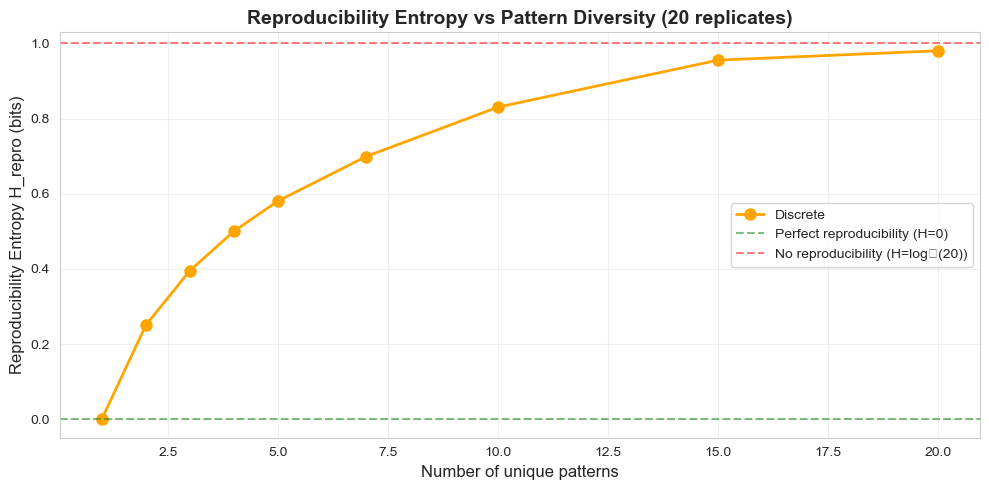


✓ Reproducibility entropy calculations correct!


In [6]:
print("Testing reproducibility entropy (H_reproducibility):")
print("=" * 50)

# Test 1: All patterns identical (perfect reproducibility)
patterns = jnp.array([[0, 1, 0, 1],
                      [0, 1, 0, 1],
                      [0, 1, 0, 1],
                      [0, 1, 0, 1]])
h_r = compute_hard_reproducibility_entropy(patterns)
print(f"\n1. All identical: H_repro = {h_r:.4f}")
print(f"   Interpretation: Perfect reproducibility")

# Test 2: All patterns unique (no reproducibility)
patterns = jnp.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 1, 0],
                      [0, 1, 1],
                      [1, 0, 0],
                      [1, 0, 1],
                      [1, 1, 0],
                      [1, 1, 1]])
h_r = compute_hard_reproducibility_entropy(patterns)
print(f"\n2. All unique: H_repro = {h_r:.4f}")
print(f"   Interpretation: No reproducibility - all patterns different")

# Test 3: Two patterns, equal frequency
patterns = jnp.array([[0, 0, 0],
                      [0, 0, 0],
                      [1, 1, 1],
                      [1, 1, 1]])
h_r = compute_hard_reproducibility_entropy(patterns)
print(f"\n3. Two patterns (50/50): H_repro = {h_r:.4f}")
print(f"   Interpretation: Moderate reproducibility")

# Test 4: Varying reproducibility
n_replicates = 20
n_unique_list = [1, 2, 3, 4, 5, 7, 10, 15, 20]
repro_entropies = []
for n_unique in n_unique_list:
    # Create n_unique distinct patterns, repeat to fill n_replicates
    patterns_list = []
    for i in range(n_replicates):
        pattern_id = i % n_unique
        # Create unique pattern from ID
        pattern = [(pattern_id >> j) & 1 for j in range(4)]  # 4 cells
        patterns_list.append(pattern)
    patterns = jnp.array(patterns_list)
    h_r = compute_hard_reproducibility_entropy(patterns)
    repro_entropies.append(h_r)

plt.figure(figsize=(10, 5))
plt.plot(n_unique_list, repro_entropies, 'o-', linewidth=2, markersize=8, color='orange', label='Discrete')
plt.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Perfect reproducibility (H=0)')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No reproducibility (H=log₂(20))')
plt.xlabel('Number of unique patterns', fontsize=12)
plt.ylabel('Reproducibility Entropy H_repro (bits)', fontsize=12)
plt.title(f'Reproducibility Entropy vs Pattern Diversity ({n_replicates} replicates)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/reproducibility_entropy_vs_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Reproducibility entropy calculations correct!")

Utility Function
================

Both entropies can be combined to give the utility function (a Kullback Leibler divergence):

Exploring diversity-reproducibility tradeoff:


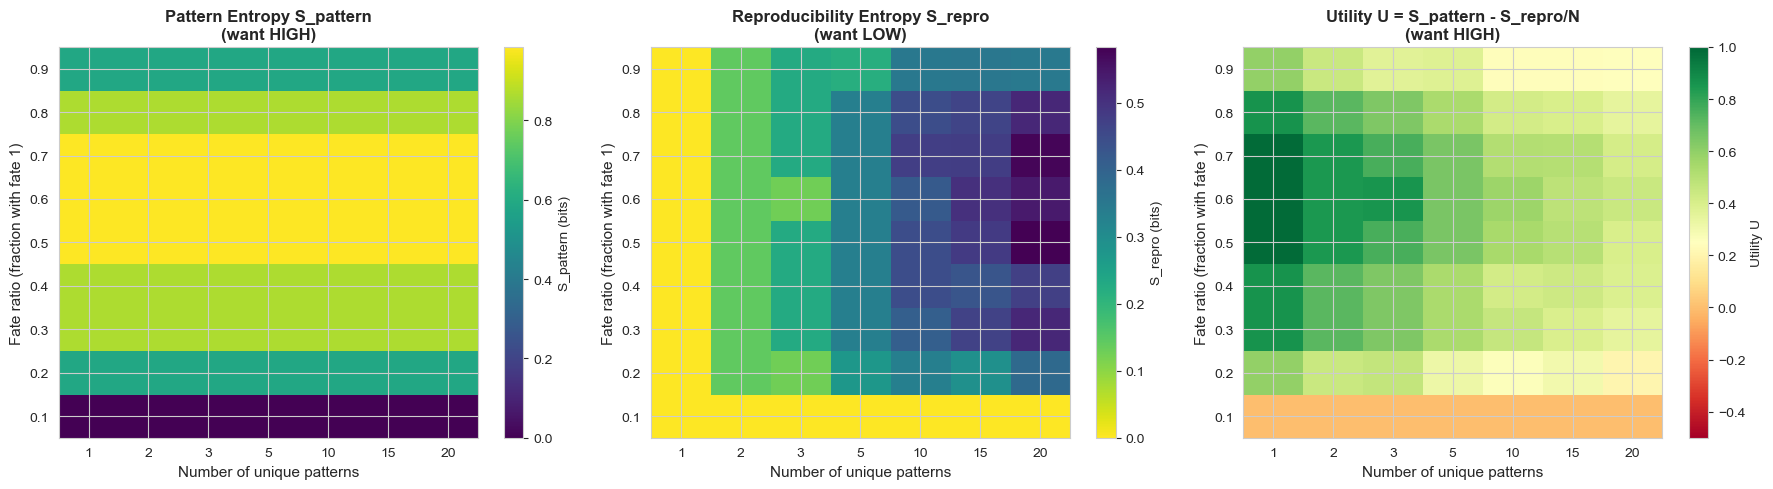


Optimal configuration:
  Fate ratio: 0.50 (close to 0.5 = balanced)
  Unique patterns: 1 (low = reproducible)
  Utility: 0.9852

✓ Best utility: high diversity (ratio ≈ 0.5) + low variability (few unique patterns)


In [7]:
print("Exploring diversity-reproducibility tradeoff:")
print("=" * 50)

n_cells = 7
n_replicates = 20

# Vary fate ratio (affects H_pattern) and n_unique patterns (affects H_repro)
fate_ratios = jnp.linspace(0.1, 0.9, 9)
n_unique_values = [1, 2, 3, 5, 10, 15, 20]

utilities = jnp.zeros((len(fate_ratios), len(n_unique_values)))
h_patterns = jnp.zeros_like(utilities)
h_repros = jnp.zeros_like(utilities)

for i, ratio in enumerate(fate_ratios):
    for j, n_unique in enumerate(n_unique_values):
        # Create patterns with specified ratio and uniqueness
        patterns_list = []
        
        # Create n_unique distinct patterns with the SAME fate ratio
        unique_patterns = []
        n_ones = int(ratio * n_cells)
        base_pattern = [0] * (n_cells - n_ones) + [1] * n_ones
        
        # Generate n_unique different permutations of the same base pattern
        for pattern_id in range(n_unique):
            pattern = base_pattern.copy()
            # Shuffle with a deterministic seed for reproducibility
            rng = random.PRNGKey(pattern_id + i * 100 + j * 1000)
            pattern = jax.random.permutation(rng, jnp.array(pattern)).tolist()
            unique_patterns.append(pattern)
        
        # Now assign these unique patterns to replicates
        for rep in range(n_replicates):
            pattern_id = rep % n_unique
            patterns_list.append(unique_patterns[pattern_id])
        
        patterns = jnp.array(patterns_list)
        u, S_pat, S_rep = compute_hard_utility(patterns)
        utilities = utilities.at[i, j].set(u)
        h_patterns = h_patterns.at[i, j].set(S_pat)
        h_repros = h_repros.at[i, j].set(S_rep)

# Plot heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# H_pattern heatmap
im1 = axes[0].imshow(h_patterns, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_xlabel('Number of unique patterns', fontsize=11)
axes[0].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[0].set_title('Pattern Entropy S_pattern\n(want HIGH)', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(n_unique_values)))
axes[0].set_xticklabels(n_unique_values)
axes[0].set_yticks(range(len(fate_ratios)))
axes[0].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im1, ax=axes[0], label='S_pattern (bits)')

# S_repro heatmap
im2 = axes[1].imshow(h_repros, aspect='auto', cmap='viridis_r', origin='lower')
axes[1].set_xlabel('Number of unique patterns', fontsize=11)
axes[1].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[1].set_title('Reproducibility Entropy S_repro\n(want LOW)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(n_unique_values)))
axes[1].set_xticklabels(n_unique_values)
axes[1].set_yticks(range(len(fate_ratios)))
axes[1].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im2, ax=axes[1], label='S_repro (bits)')

# Utility heatmap
im3 = axes[2].imshow(utilities, aspect='auto', cmap='RdYlGn', origin='lower', vmin=-0.5, vmax=1.0)
axes[2].set_xlabel('Number of unique patterns', fontsize=11)
axes[2].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[2].set_title('Utility U = S_pattern - S_repro/N\n(want HIGH)', fontsize=12, fontweight='bold')
axes[2].set_xticks(range(len(n_unique_values)))
axes[2].set_xticklabels(n_unique_values)
axes[2].set_yticks(range(len(fate_ratios)))
axes[2].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im3, ax=axes[2], label='Utility U')

plt.tight_layout()
plt.savefig('../figures/utility_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best parameter combination
best_i, best_j = jnp.unravel_index(jnp.argmax(utilities), utilities.shape)
print(f"\nOptimal configuration:")
print(f"  Fate ratio: {fate_ratios[best_i]:.2f} (close to 0.5 = balanced)")
print(f"  Unique patterns: {n_unique_values[best_j]} (low = reproducible)")
print(f"  Utility: {utilities[best_i, best_j]:.4f}")
print(f"\n✓ Best utility: high diversity (ratio ≈ 0.5) + low variability (few unique patterns)")


The Soft Utility
===============

The problem with the pattern entropy is that it is not differentiable, since we count unique patterns. We have to smooth the process at two steps: We have to apply a soft threshold and we have to use a Kernel density estimate to not count sharp patterns but similarity between patterns.

In [8]:
from utility_function import apply_soft_threshold, compute_soft_pattern_prob_distribution

In [9]:
# Some test states
states = jnp.array([0.2, 0.7, 0.51, 0.9, 0.1])
print("Testing soft thresholding:")
soft_fates = apply_soft_threshold(states, temperature=20.0)
print(soft_fates)

Testing soft thresholding:
[2.4726230e-03 9.8201376e-01 5.4983395e-01 9.9966466e-01 3.3535014e-04]


If we have multiple of these state-arrays, we can apply the soft threshold and then apply the density kernel approximation to know the resulting pattern:

In [10]:
from dynamics import apply_threshold

state_array = jnp.array([[0.2, 0.7, 0.6], [0.9, 0.1, 0.4], [0.2, 0.9, 0.45]])
soft_states = apply_soft_threshold(state_array, temperature=20.0)
hard_states = apply_threshold(state_array)

print("Soft states:")
print(soft_states)
print("Hard states:")
print(hard_states)

print("Calculate pattern probability distribution:")
print(f"Hard distribution: {compute_pattern_prob_distribution(hard_states)}")
print(f"Soft distribution: {compute_soft_pattern_prob_distribution(soft_states)}")

Soft states:
[[2.47262302e-03 9.82013762e-01 8.80797148e-01]
 [9.99664664e-01 3.35350138e-04 1.19202934e-01]
 [2.47262302e-03 9.99664664e-01 2.68941373e-01]]
Hard states:
[[0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Calculate pattern probability distribution:
Hard distribution: [0.33333334 0.33333334 0.33333334 0.         0.         0.
 0.         0.        ]
Soft distribution: [0.33333334 0.33333334 0.33333334]


With this, we can define a soft utility function:

In [11]:
from utility_function import compute_soft_utility, compute_soft_loss

states = jnp.array([[0.2, 0.7, 0.6], [0.9, 0.1, 0.4], [0.2, 0.9, 0.45]])
soft_fates = apply_soft_threshold(states, temperature=20.0)
u_soft, S_pat_soft, S_rep_soft = compute_soft_utility(soft_fates, bandwidth=0.1)

print("Soft utility calculations:")
print(f"Soft fates: {soft_fates}")
print(f"Hard fates: {apply_threshold(states)}")
print(f"U_soft: {u_soft}, S_pat_soft: {S_pat_soft}, S_rep_soft: {S_rep_soft}")

Soft utility calculations:
Soft fates: [[2.47262302e-03 9.82013762e-01 8.80797148e-01]
 [9.99664664e-01 3.35350138e-04 1.19202934e-01]
 [2.47262302e-03 9.99664664e-01 2.68941373e-01]]
Hard fates: [[0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
U_soft: 0.46954968571662903, S_pat_soft: 0.9978705644607544, S_rep_soft: 0.5283209085464478


Exploring diversity-reproducibility tradeoff:


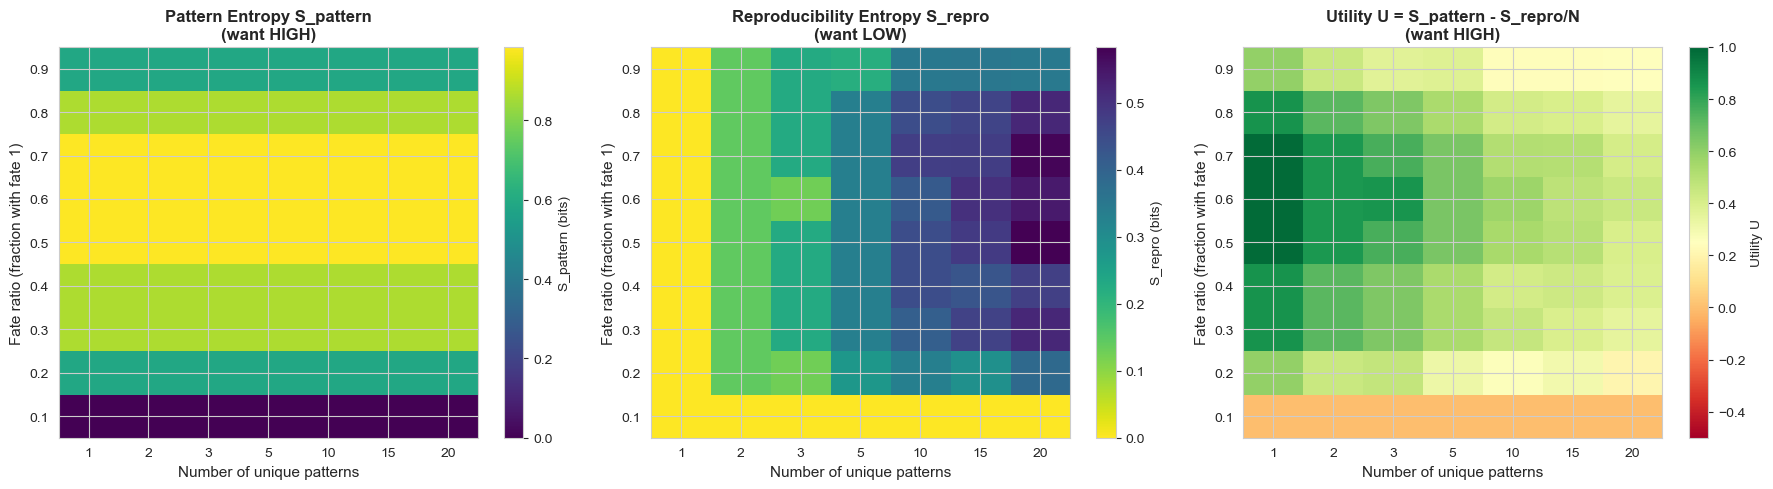


Optimal configuration:
  Fate ratio: 0.50 (close to 0.5 = balanced)
  Unique patterns: 1 (low = reproducible)
  Utility: 0.9852

✓ Best utility: high diversity (ratio ≈ 0.5) + low variability (few unique patterns)


In [12]:
print("Exploring diversity-reproducibility tradeoff:")
print("=" * 50)

n_cells = 7
n_replicates = 20

# Vary fate ratio (affects H_pattern) and n_unique patterns (affects H_repro)
fate_ratios = jnp.linspace(0.1, 0.9, 9)
n_unique_values = [1, 2, 3, 5, 10, 15, 20]

utilities = jnp.zeros((len(fate_ratios), len(n_unique_values)))
h_patterns = jnp.zeros_like(utilities)
h_repros = jnp.zeros_like(utilities)

for i, ratio in enumerate(fate_ratios):
    for j, n_unique in enumerate(n_unique_values):
        # Create patterns with specified ratio and uniqueness
        patterns_list = []
        
        # Create n_unique distinct patterns with the SAME fate ratio
        unique_patterns = []
        n_ones = int(ratio * n_cells)
        base_pattern = [0] * (n_cells - n_ones) + [1] * n_ones
        
        # Generate n_unique different permutations of the same base pattern
        for pattern_id in range(n_unique):
            pattern = base_pattern.copy()
            # Shuffle with a deterministic seed for reproducibility
            rng = random.PRNGKey(pattern_id + i * 100 + j * 1000)
            pattern = jax.random.permutation(rng, jnp.array(pattern)).tolist()
            unique_patterns.append(pattern)
        
        # Now assign these unique patterns to replicates
        for rep in range(n_replicates):
            pattern_id = rep % n_unique
            patterns_list.append(unique_patterns[pattern_id])
        
        patterns = jnp.array(patterns_list)
        u, S_pat, S_rep = compute_soft_utility(patterns)
        utilities = utilities.at[i, j].set(u)
        h_patterns = h_patterns.at[i, j].set(S_pat)
        h_repros = h_repros.at[i, j].set(S_rep)

# Plot heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# H_pattern heatmap
im1 = axes[0].imshow(h_patterns, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_xlabel('Number of unique patterns', fontsize=11)
axes[0].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[0].set_title('Pattern Entropy S_pattern\n(want HIGH)', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(n_unique_values)))
axes[0].set_xticklabels(n_unique_values)
axes[0].set_yticks(range(len(fate_ratios)))
axes[0].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im1, ax=axes[0], label='S_pattern (bits)')

# S_repro heatmap
im2 = axes[1].imshow(h_repros, aspect='auto', cmap='viridis_r', origin='lower')
axes[1].set_xlabel('Number of unique patterns', fontsize=11)
axes[1].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[1].set_title('Reproducibility Entropy S_repro\n(want LOW)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(n_unique_values)))
axes[1].set_xticklabels(n_unique_values)
axes[1].set_yticks(range(len(fate_ratios)))
axes[1].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im2, ax=axes[1], label='S_repro (bits)')

# Utility heatmap
im3 = axes[2].imshow(utilities, aspect='auto', cmap='RdYlGn', origin='lower', vmin=-0.5, vmax=1.0)
axes[2].set_xlabel('Number of unique patterns', fontsize=11)
axes[2].set_ylabel('Fate ratio (fraction with fate 1)', fontsize=11)
axes[2].set_title('Utility U = S_pattern - S_repro/N\n(want HIGH)', fontsize=12, fontweight='bold')
axes[2].set_xticks(range(len(n_unique_values)))
axes[2].set_xticklabels(n_unique_values)
axes[2].set_yticks(range(len(fate_ratios)))
axes[2].set_yticklabels([f"{r:.1f}" for r in fate_ratios])
plt.colorbar(im3, ax=axes[2], label='Utility U')

plt.tight_layout()
plt.savefig('../figures/utility_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best parameter combination
best_i, best_j = jnp.unravel_index(jnp.argmax(utilities), utilities.shape)
print(f"\nOptimal configuration:")
print(f"  Fate ratio: {fate_ratios[best_i]:.2f} (close to 0.5 = balanced)")
print(f"  Unique patterns: {n_unique_values[best_j]} (low = reproducible)")
print(f"  Utility: {utilities[best_i, best_j]:.4f}")
print(f"\n✓ Best utility: high diversity (ratio ≈ 0.5) + low variability (few unique patterns)")

In [ ]:
Hi, this folder holds a little project (expected attendance of 1 or two days) for a potential phd project. it is the "warmup", so nothing too fany. The idea is to model cell fate decisions. We mode a cell as having a state s which can evolve in time using a regulator function f. After some time we apply a threshold to this state and bring it to be either 1 or 0. For some cells side by side, we call the result a pattern. A system under noise will create different patterns with different frequency for different regulator functions f. We can gauge how "good" a system does by measuring how much information a pattern holds (pattern entropy) and how unrealible this pattern is produced (reproduction entropy). By subtracting both, we get a utility function that can be used to gauge how well a regulator function $f$ does. The idea is now to replace this regulator function $f$ with a small neural network that represents the GeneRegulatoryNetwork inside every cell that is trained by evolution. For this mini-project the cells can only talk to their neighbors and only feel the avergage state of the direct  neighbors. I have already written some code in the current repository. The next steps would be to actually train the neural network in a new notebook 04TrainingTheNetwork which does not yet exist. After that, we should visaulise the results. We expect that the trained network approaches a tanh function for the regulator. Since this is the first time I am using you on this project, i would like you to tell me how we should best start? Should you create an agents.md file e.g.?